# Read Me

This notebook has the objective to reverse engineer/aproximate state of the art sentiment analysis algorithms that govern different exchange markets. The assumption that is being made is that the majority of the movement of markets is determined from algorithmic trading and machines, sentiment analysis of the masses being one of the main ones. Following this, we can expect to iteratively develop algorithms that should aproximate/predict the market indeces. 

The intent is not to find market inefficiencies or to beat the market, a hurdle to big any individual to takle nowadays. The goal is to get as close as possible to the algorithms used today in the industry.

## Predicting with Tweet Volume (V 1.0)
 

To start off we will create a model that searches for keywords on twitter to predict predefined stock prices. As of now we will plot the frequency (tweets per minute) of a keyword next to the graph of a predifined stock index.

#### 1. Import necessary libaries
Tweepy is Twitter's API that allows us to convieniently search their database of tweets according to author, keywords, popularity and other handy features.

In [1]:
import tweepy
import matplotlib.pyplot as plt
import json
import requests

#### 2. Do necessary authentications
The following is what allows us to access the twitter API
TODO: Find way to hide them

In [2]:
consumer_key= 'gXtUH5IaLialLO71v1QZhs7rF'
consumer_secret= 'A4tHrkqZ6D96dCGwNLOuRBd0juO8qOpaaP89oUmoPrZNxcWNBj' # Secret
access_token='1027935030360850432-RLhwU4GVbCtrE3cu2PyxfTFBIoVOx1'
access_token_secret='wK62J222AcJso04D6Vpuge5kQbzlW4NJofGM1ncuHFtri' # Secret

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

#### 3. Search the tweets
Now we search for the tweets we want to retrieve. In this demo we will use the keyword "Elon Musk" to predict Tesla's Stock price (TSLA).
Twitter limits the amount of tweets we can receive 'per search' to 100. We must therefore concatenate multiple search to get a statistically significant amount of data. Tweepy, though, also limits the number of requests you can do every 15 minutes (<180). 
Another problem is tweepy doesn't make all tweets available but only the ones of the last 6-9 days.

We are gonna store the tweets we fetched in `tweets_to_analyse`

In [3]:
searchQuery = "LIKE 'elonmusk'" # Keyword
tweets_to_analyse = [] # All the tweets 

number_of_requests = 30
max_id = float('inf') # This is because the first time we search we dont want any max ID

for i in range(number_of_requests):
    tweets = api.search(q=searchQuery, count=100, #tweets for this search
                        result_type = "recent",
                        max_id = max_id,
                        lang = "en")
    print(int(i/number_of_requests*100), "%") #This is a loading bar
    tweets_to_analyse.extend(tweets)
    
    if(len(tweets) < 100): #if no more tweets are available
        break
        
    max_id = tweets[99].id #get the id of the last item

print("We have retrieved %s tweets" % len(tweets_to_analyse))

0 %
3 %
6 %
10 %
13 %
16 %
20 %
23 %
26 %
30 %
We have retrieved 985 tweets


In [4]:
query = 'Elon Musk'
max_tweets = 1000
tweets_to_analyse = [status for status in tweepy.Cursor(api.search, q=query).items(max_tweets)]
print(len(tweets_to_analyse))


1000


#### 4. Plotting Volume of tweets
We now want to visualise this data. The idea is that if I have 100 tweets, I get the first and last's timestamps and set my x-axis (time) to have those as extremes. After that i get the tweets that are multiples of 10 and measure the frequency of tweets 

#works i don't know why

In [5]:
from datetime import datetime

number_of_buckets = 10 #This determines how precise we want our graph to be (how many points to have)

#get the time delta between our first and last registered (timedelta object)
most_recent_timestamp = tweets_to_analyse[0].created_at # this is our 0. We count back in minutes from here
oldest_timestamp = tweets_to_analyse[len(tweets_to_analyse)-1].created_at
total_data_time = most_recent_timestamp - oldest_timestamp #this is the datetime.timedelta that rapresents the amount of time we recorded

delta_in_seconds = -total_data_time.total_seconds() / number_of_buckets #this is negative

#generate the x values
x_data = [0] * number_of_buckets
print(total_data_time)
for i in range(number_of_buckets):
    x_data[i] = (delta_in_seconds * (i+1))/60

#initialize array for y values
tweet_volume = [0] * number_of_buckets
#calculate y values
current_bucket_number = 0
for tweet in tweets_to_analyse:
    #print("bucket number:", current_bucket_number)
    #print("is", (tweet.created_at - most_recent_timestamp).total_seconds(), "smaller than", ((current_bucket_number+1) * delta_in_seconds))
    #print((tweet.created_at - most_recent_timestamp).total_seconds() < (current_bucket_number+1) * delta_in_seconds)
    tweet_volume[current_bucket_number] += 1
    if ((tweet.created_at - most_recent_timestamp).total_seconds() < ((current_bucket_number+1) * delta_in_seconds)):
        current_bucket_number += 1

print(tweet_volume)
    

0:25:45
[90, 106, 104, 103, 105, 84, 79, 115, 102, 112]


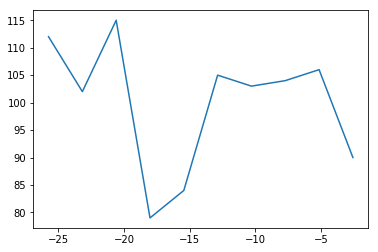

In [6]:
plt.plot(x_data, tweet_volume, label = "tweet volume")

In [7]:
time_in_minutes_elapsed_since_oldest = int((datetime.now() - oldest_timestamp).total_seconds()/60)
time_in_minutes_elapsed_since_oldest

147

5 5 0:25:45
[0, -5, -10, -15, -20]


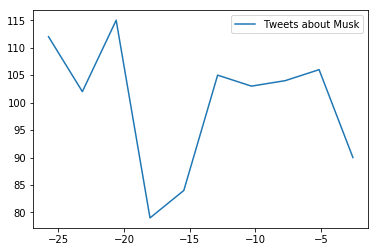

In [12]:
###############GET STOCK DATA#################################
#Get data from stock api
response = requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=TSLA&interval=5min&apikey=H882E1XRM4DIVG86&outputsize=full") #size to full for full day
json_data = json.loads(response.text)

# set up the minute increment
x_values = [-x for x in list(range(0, int(total_data_time.total_seconds()/60), 5))] # these are timestamps that count back from the present to the oldest tweet in increments of 1 minute
prices = []

counter = 0
for data in json_data['Time Series (5min)']:
    if (counter >=int(total_data_time.total_seconds()/60/5)): #Only get the last x minutes worth of data
        break
    data = float((json_data['Time Series (5min)'][data]["1. open"]))
    prices.append(data)
    counter += 1

print(len(prices), len(x_values), total_data_time)
print(x_values)
#plt.plot(x_values, prices, label = "TSLA price")
plt.plot(x_data, tweet_volume, label = "Tweets about Musk")
plt.legend()

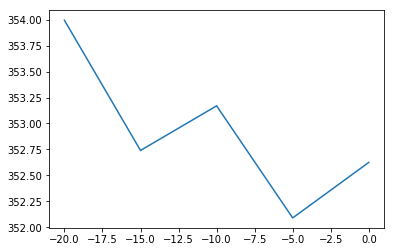

In [13]:
plt.plot(x_values, prices, label = "TSLA price")

## Is there positive correlation between tweet sentiment and stock price?
We are going to use textblob library to perform sentiment analysis on each of the tweets that will score the tweet on a scale from -1 to +1 where -1 is a negative sentiment, 0 and objective statement or a statement without sentiment and +1 a positive statement.

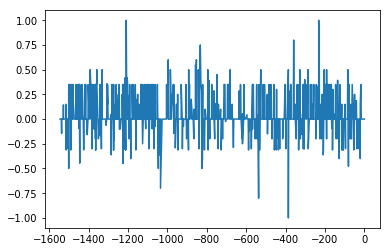

In [21]:
from textblob import TextBlob

x_values = [] # the timestamps of the tweets, counting backwards from present
y_values = [] # the sentiment of the tweets [-1; +1]
for tweet in tweets_to_analyse:
    tweet_date = tweet.created_at
    rel_date = tweet_date - most_recent_timestamp
    x_values.append(rel_date.total_seconds())
    y_values.append(TextBlob(tweet.text).sentiment.polarity)
    
plt.plot(x_values, y_values, label = "Tweet sentiment")

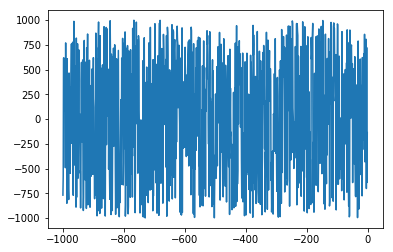

In [24]:
import random
plt.plot(range(-1000, 0), random.sample(range(-1000, 1000), 1000))
